In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct  6 12:17:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -r yolov5/requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -f '/content/gdrive/MyDrive/sit789_assignment_5_2_data/RoadSignDetectionDataset.zip' '/content/'
!rm -rf RoadSignDetectionDataset
!mkdir RoadSignDetectionDataset
!unzip /content/RoadSignDetectionDataset.zip -d /content/RoadSignDetectionDataset/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/RoadSignDetectionDataset.zip
  inflating: /content/RoadSignDetectionDataset/annotations/road0.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road1.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road10.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road100.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road101.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road102.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road103.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road104.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road105.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road106.xml  
  inflating: /content/RoadSignDetectionDataset/annotations/road107.xml  
  inflating: /content/R

In [5]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [6]:
print(extract_info_from_xml('/content/RoadSignDetectionDataset/annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [7]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("./annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [11]:
%cd /content/RoadSignDetectionDataset

/content/RoadSignDetectionDataset
/content/RoadSignDetectionDataset


In [12]:
# Get the annotations
annotations = [os.path.join('./annotations', x) for x in os.listdir('./annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('./annotations', x) for x in os.listdir('./annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 6939.27it/s]


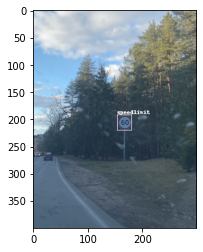

In [19]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [20]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [21]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test 

In [22]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [26]:
!mv annotations labels
%cd ../yolov5 

mv: cannot stat 'annotations': No such file or directory
/content/yolov5


In [27]:
!pwd

/content/yolov5


In [31]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-high.yaml --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=road_sign_data.yaml, hyp=hyp.scratch-high.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

In [43]:
model_name = "/content/yolov5/runs/train/yolo_road_det3/weights/best.pt"
test_model = torch.hub.load("ultralytics/yolov5", 'custom', model_name)
test_model.conf = 0.25  # confidence threshold (0-1)
test_model.iou = 0.45
test_model.eval()

test_path = "/content/RoadSignDetectionDataset/"
test_files = glob.glob(test_path + "/images/test/*")
labels = ["trafficlight", "stop", "speedlimit", "crosswalk"]

for files in test_files:
  test_image = cv2.imread(files)
  file_basename = os.path.basename(files)
  print (file_basename)
  txt_name = file_basename[:file_basename.rfind(".")] + ".txt"
  txt_file = open(test_path + "/labels/test/" + txt_name, "r")
  data = txt_file.read()
  data_into_list = data.split("\n")
  #print(data_into_list)

  results = test_model(test_image, size=640) 
  results_df = results.pandas().xyxy
  print (results_df[0].name)

  print("\n")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-6 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


road113.png
0    speedlimit
Name: name, dtype: object


road801.png
0    speedlimit
Name: name, dtype: object


road486.png
0      speedlimit
1    trafficlight
Name: name, dtype: object


road385.png
0    speedlimit
Name: name, dtype: object


road679.png
0    speedlimit
Name: name, dtype: object


road360.png
0    speedlimit
Name: name, dtype: object


road599.png
0    speedlimit
Name: name, dtype: object


road563.png
0    speedlimit
1     crosswalk
Name: name, dtype: object


road731.png
0    speedlimit
1    speedlimit
Name: name, dtype: object


road418.png
0    speedlimit
Name: name, dtype: object


road316.png
0    speedlimit
1    speedlimit
2     crosswalk
Name: name, dtype: object


road709.png
0    speedlimit
1    speedlimit
Name: name, dtype: object


road80.png
0    stop
Name: name, dtype: object


road50.png
0    trafficlight
Name: name, dtype: object


road809.png
0    speedlimit
Name: name, dtype: object


road403.png
0    speedlimit
Name: name, dtype: object


road590.pn

In [42]:
!python val.py --weights runs/train/yolo_road_det3/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

val: data=/content/yolov5/data/road_sign_data.yaml, weights=['runs/train/yolo_road_det3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/RoadSignDetectionDataset/labels/test' images and labels...88 found, 0 missing, 0 empty, 0 corrupt: 100% 88/88 [00:00<00:00, 2895.35it/s]
test: New cache created: /content/RoadSignDetectionDataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:02<00:00,  1.14it/s]
                   all         88        126  